<h1> Predicting Board Game Reviews using KMeans Clustering and Linear Regression </h1>

Board games have been making a comeback lately, and deeper, more strategic boardgames, like Settlers of Catan have become hugely popular. BoardGameGeek is a popular site where these types of board games are discussed and reviewed.

Here we have a dataset that contains 80000 board games and their associated review scores. The data was scraped from BoardGameGeek and compiled into CSV format by Sean Beck.

Let's preview the data and look at some interesting columns. 

In [73]:
import pandas as pd
board_games = pd.read_csv("board_games.csv")
board_games.head(5)

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


Each row represents a single board game and has descriptive statistics about the board game, as well as review information. Some of the interesting columns are : 

<ul>
<li><b>name</b> -- name of the board game. </li>
<li><b>playingtime</b> -- the playing time (given by the manufacturer). </li>
<li><b>minplaytime</b>-- the minimum playing time (given by the manufacturer). </li> 
<li><b>maxplaytime</b> -- the maximum playing time (given by the manufacturer). </li>
<li><b>minage</b> -- the minimum recommended age to play. </li>
<li><b>users_rated</b> -- the number of users who rated the game. </li>
<li><b>average_rating</b> -- the average rating given to the game by users. (0-10)</li>
<li><b>total_weights</b> -- Number of weights given by users. Weight is a subjective measure that is made up by          BoardGameGeek. It describes how "deep" or involved a game is. </li>
<li><b>average_weight</b> -- the average of all the subjective weights (0-5). </li>
</ul>

One interesting machine learning task might be to predict <b> average_rating </b> using the other columns. The dataset contains quite a few missing values, and rows where there are no reviews, where the score is 0. Let's remove them.


In [74]:
board_games = board_games.dropna(axis=0)
board_games = board_games[board_games["users_rated"]>0]

board_games.head()

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


Since we are trying to predict the <b> average_rating </b> column using other columns let's visualize and explore it a little.  


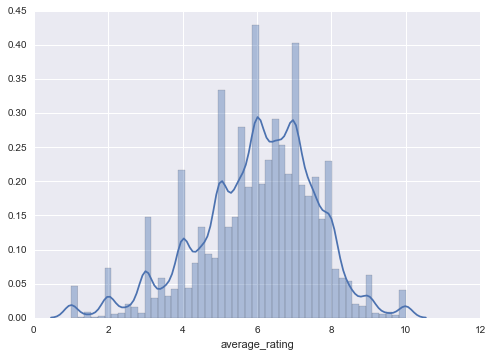

In [75]:
import seaborn as sns
%matplotlib inline

sns.set(color_codes="True")
sns.distplot(board_games["average_rating"])



As we can see in the histogram above that most average_ratings lie around ~6. Let's confirm our inference and calculate the standard deviation and mean for the <b> average_rating </b> column.

In [76]:
sd = board_games["average_rating"].std()
mean = board_games["average_rating"].mean()

print(sd,mean)

1.5788299348332662 6.016112849333889


<h2> Clustering and Error Metrics </h2>

To look for patterns in the data we are going to use a clustering algorithm to create clusters in the data and plot them out. A good first choice would be the <b> Kmeans</b> class from the scikit-learn library in Python. The KMeans class only works with numeric columns, so numeric columns of our dataset will be extracted out. 

As the data is continuous it might be a good idea to use mean squared error as an error metric. The mean square error will penalize larger errors in our model more. 

For the cluster assingment we find the mean and standard deviation of each row, then make a scatterplot for mean vs standard deviation and shade the points according to their cluster assignment.

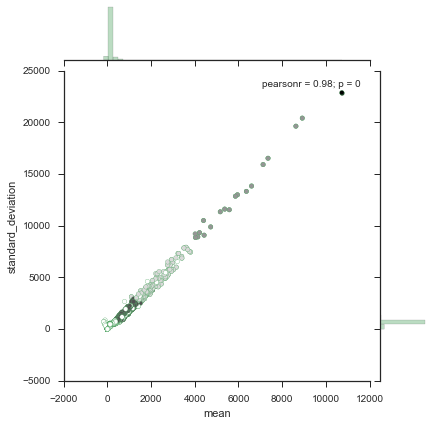

In [77]:
from sklearn.cluster import KMeans
import numpy as np
from pandas import DataFrame
%matplotlib inline

kmodel = KMeans(n_clusters=5, random_state=1)
board_games_numeric = board_games.drop(['name','type','id'],axis=1)
kmodel.fit(board_games_numeric)

games_mean = board_games_numeric.apply(np.mean, axis=1)
games_std = board_games_numeric.apply(np.std, axis=1)

labels = kmodel.labels_
df = DataFrame()
df["mean"] = games_mean
df["standard_deviation"] = games_std
sns.set_style(style="ticks")
sns.jointplot(x="mean", y="standard_deviation", data=df, c=labels, color="g")






Looking at the clusters above in different shades of green it can be observed that most of the games are similar in their distribution across parameters. But as the attributes tend to increase (increase in mean), say because of the number of users who rated the game are high (<b>users_rated</b> column), we have fewer and fewer games. 

The <b> users_rated </b> column specifies the number of users who rated the game, hence a possible take away from a higher attribute value is that a few games get rated by a lot of users, but most games don't get played much.

Next, let's figure out which columns correlate well with <b> average_rating </b>. This would allow us to remove columns that do not add much predictive power to our model. 

We will be using a regression model to predict average ratings and columns that are uncorrelated with the target don't help a linear regression model. It also enables us to remove columns that are derived from the target, or could otherwise cause overfitting. 

<h2> Correlations </h2>

In [78]:
correlations = board_games_numeric.corr()

correlations["average_rating"] #Shows us how each column in board game dataset is correlated with average_rating

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64

Correlations tell you what columns are closely related to the column you are interested in. The closer to 0 the correlation, the weaker the connetion. The closer to 1, the stronger the positive correlation, and the closer to -1, the stronger the negative correlation. 

As we see above a couple of columns show higher values of correlating with our average_rating column. The <i>average_weight</i> column seems to be correlated with our average_rating column implying the more  "weight" a game has the more highly it tends to be rated. Weight is a subjective measure that is made up by BoardGameGeek. It describes how "deep" or involved a game is.

We can also note that games for older players, where <i> minage </i> is high, tend to have higher average rating. The <i>yearpublished</i> correlation values tell us that newer games tend to have a higher rating. 

The <i> bayes_average_rating </i> column seems to be calculated from the average_rating column in our dataset, and therefore will be removed as it will cause our model to overfit.


<h2> Modelling and Validation </h2>
We are going to create a linear regression model to make predictions for newly created board games. Let's see the performance of the model on just the training set. As discussed before, we'll drop the highly correlated columns from the dataset and use all numerical colums as input predictors to our model. The <i> average_rating </i> column will be our target output.


In [134]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error 

board_games_numeric2 = board_games_numeric.drop(['average_rating','bayes_average_rating'],axis=1)


lr = LinearRegression()
lr.fit(board_games_numeric2, board_games["average_rating"])
predictions = lr.predict(board_games_numeric2)


mse = mean_squared_error(board_games["average_rating"],predictions)
print(mse)
rmse = mse ** (1/2)
print(rmse)


2.09339697583
1.44685762113


We obtained a mean square error of 2.09. Let's see how our predictions plot over the actual average_ratings.

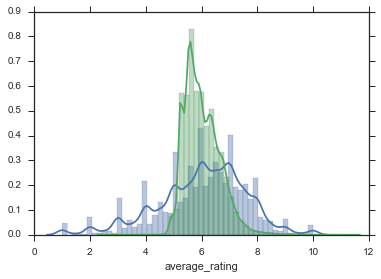

In [94]:
sns.distplot(board_games["average_rating"])
sns.distplot(predictions)


<h2> K-Folds Cross Validation </h2>

We now split our data into training and test sets, train our algorithm on the training sets and test its performance on our test sets. For validation purposes we will use K-folds cross validation to see if our predictive model can be improved. 

In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data. The k results from the folds can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling (see below) is that all observations are used for both training and validation, and each observation is used for validation exactly once. 10-fold cross-validation is commonly used, but in general k remains an unfixed parameter.  [(Source)](https://en.wikipedia.org/wiki/Cross-validation_(statistics)

In this case we use K=10 folds. To see how the good the model actually is we can compare our mean squared error to the standard deviation.

2.09490764514
1.4473795788


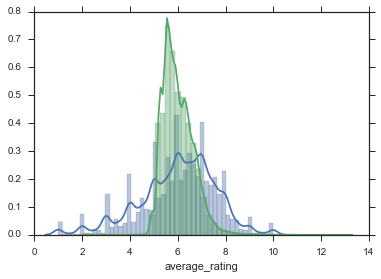

In [135]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict

x = board_games_numeric2
y = board_games["average_rating"]

kf = KFold(len(board_games_numeric2),10, shuffle=True, random_state=8)
mse = cross_val_score(lr,x, y, scoring= 'mean_squared_error', cv=kf)
averagemse = np.mean(mse)
print(abs(averagemse))
rmse = (abs(averagemse) ** (1/2))
print(rmse)

predicted = cross_val_predict(lr,x,y,cv=kf)
sns.distplot(board_games["average_rating"])
sns.distplot(predicted)



As we can see K-folds cross validation did not significantly improve our model accuracy, with our MSE still at 2.09. Our model may not have high predictive powers as our mean square error is close to the standard deviation of game ratings. We would need to dig deeper into our dataset to obtain a better understanding. Some of the potential next steps could be :
<ui>
<li> Calculate new predictors based off other existings columns such as player ranges (maxplayers-minplayers) </li>
<li> Scraping more data from BoardGameGeek to increase the size of the dataset. </li>
<li> Try algorithms other than linear regression </li>
